In [1]:
import tensorcraft as tc
import numpy as np
import matplotlib.pyplot as plt


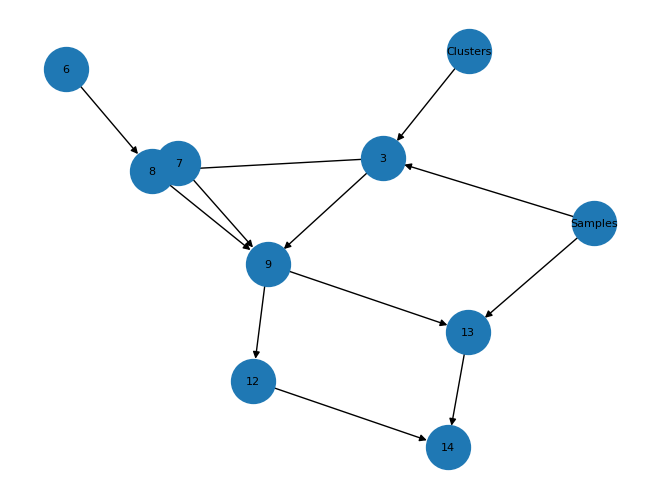

In [2]:
import importlib
import matplotlib.pyplot as plt
import networkx as nx

importlib.reload(tc)
from tensorcraft.compiler.compiler import ProgramTransformer
code = """
# Distance computation
Dist[j,k] = (Samples[j,l] - Clusters[k,l]) * (Samples[j,l] - Clusters[k,l])

# Argmin
Min[j] = 1000
Labels[j] = -1
Min[j] = (Dist[j,k] < Min[j]) * (Dist[j,k] - Min[j])
Labels[j] = (Dist[j,k] == Min[j]) * (k - Labels[j])

# Cluster update
Count[l] = (Labels[j] == l)
Update[l,k] = Samples[j,k] * (Labels[j] == l)
Update[l,k] = Update[l,k] / Count[l]
"""
tree = tc.compile(code)

kmeans_kernel = ProgramTransformer(code).transform(tree)
# pos = nx.drawing.bfs_layout(dataGraph, "X", align="vertical")
nx.draw_kamada_kawai(kmeans_kernel.graph, with_labels=True, font_size=8, node_size=1000)

{'G_c': [0, 0], 'D_c': [50, 0], 'A': [100, 0], 'X_c': [150, 0], 2: [4, -2], 3: [5, -3], 4: [6, -4], 6: [7, -6], 7: [8, -7], 8: [9, -8], 10: [10, -10], 11: [11, -11], 12: [12, -12]}


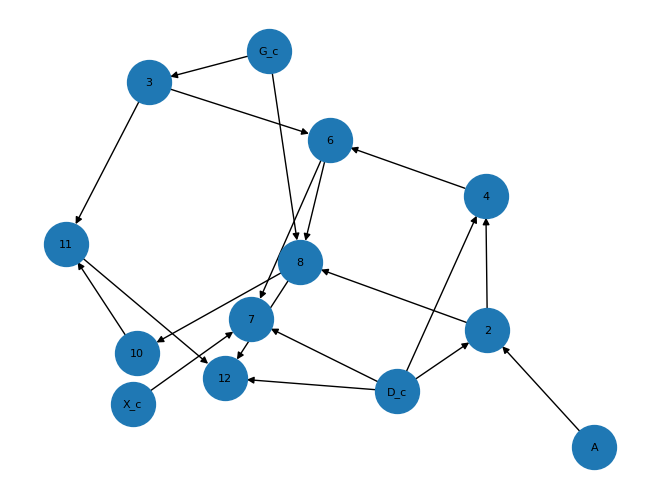

In [5]:

import importlib
import matplotlib.pyplot as plt
import networkx as nx

from tensorcraft.compiler.model import Program

importlib.reload(tc)
from tensorcraft.compiler.compiler import ProgramTransformer
code = """
W_c[i] = A[i,j] * D_c[j]
Gamma_c = G_c[i] * G_c[i]
Theta_c = D_c[i] * W_c[i]

Alpha_c = Gamma_c / Theta_c
X_n[i] = X_c[i] + Alpha_c * D_c[i]
G_n[i] = G_c[i] + Alpha_c * W_c[i]

Gamma_n = G_n[i] * G_n[i]
Beta_n = Gamma_n / Gamma_c
Delta_n = Beta_n * D_c[i] - G_n[i]
"""
tree = tc.compile(code)

conjugate_gradient_kernel: Program = ProgramTransformer(code).transform(tree)

pos = {node: [i*50, 0] if type(node) == str else [i, -node] for i, node in enumerate(conjugate_gradient_kernel.graph)}
print(pos)
pos = nx.kamada_kawai_layout(conjugate_gradient_kernel.graph, pos=pos, center=[len(pos.keys())/2,25])
# pos = nx.bfs_layout(conjugate_gradient_kernel.graph, start=conjugate_gradient_kernel.input_variables[0], align="vertical")
# pos = nx.spring_layout(conjugate_gradient_kernel.graph, pos=pos, fixed=conjugate_gradient_kernel.input_variables)
nx.draw(conjugate_gradient_kernel.graph, pos=pos, with_labels=True, font_size=8, node_size=1000)

In [4]:
for n in conjugate_gradient_kernel.graph:
    print(n)
pos

G_c
D_c
A
X_c
2
3
4
6
7
8
10
11
12


{'G_c': array([0., 0.]),
 'D_c': array([50.,  0.]),
 'A': array([100.,   0.]),
 'X_c': array([150.,   0.]),
 2: array([  85.30178144, -159.92278018]),
 3: array([ 132.81698963, -132.89170591]),
 4: array([ -94.11743219, -143.95000944]),
 6: array([ -39.39333579, -120.01559711]),
 7: array([-346.83912333,  -76.31321949]),
 8: array([ 271.05511109, -161.39054952]),
 10: array([ 215.46698457, -188.41434245]),
 11: array([ 303.17265022, -142.74072982]),
 12: array([ 362.0051928 , -119.83273844])}